# PyPI project classification based on package description

This is an experimental notebook with the goal of exploring different methods to extend [project2vec](https://developers.redhat.com/articles/2021/10/06/find-and-compare-python-libraries-project2vec).

The data used for this project consists in information about ~70 000 Python packages aggregated from PyPI using [Selinon](https://github.com/thoth-station/selinon-worker) and is available under ``s3://DH-DEV-DATA/data/thoth/selinon/pypi_project/ProjectInfo/`` on Ceph.

## Data description

Each file describes a different package hosted on PyPI, providing metadata about the project in the `info` field. We are interested in the following subfields:
- `classifiers`
- `keywords`
- `description`

The classifiers of a project consist in a hierchical labels, with their [official list](https://pypi.org/classifiers/) described on the PyPI website. They allow to classify a project according to different categories and scopes, for example by language and version, operating system or topic. In the case of the `selinon` package, the classifiers are the following:

```
      "Development Status :: 4 - Beta",
      "Intended Audience :: Developers",
      "License :: OSI Approved :: BSD License",
      "Operating System :: OS Independent",
      "Programming Language :: Python :: 3",
      "Programming Language :: Python :: 3.4",
      "Programming Language :: Python :: 3.5",
      "Programming Language :: Python :: 3.6",
      "Programming Language :: Python :: Implementation :: CPython",
      "Programming Language :: Python :: Implementation :: PyPy",
      "Topic :: System :: Distributed Computing"
```

The keywords consist in a few words written in free text format (often separated by a whitespace or a coma) describing the package in a non-hierchical way. The keywords chosen to describe `selinon` are:

``selinon celery yaml flow distributed-computing``

Finally, the description is the text describing the project as seen in the PyPI pakage page.


## Creation of a raw content dataset

Let's create datasets of descriptions from those PyPI projects and link each project and its description respectively to its trove classifiers and keywords from PyPI.
The dataset should contain the following information:

``Project name | Project description | Project PyPI classifiers or Project PyPI keywords``

In [3]:
from collections import OrderedDict
import csv
import json
import nltk
from nltk.corpus import stopwords
import os
import pandas as pd
from pprint import PrettyPrinter
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from typing import Dict
from typing import List

2022-03-04 17:33:37,285 [345774] WARNING  py.warnings: /home/mcostant/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])

2022-03-04 17:33:37,287 [345774] WARNING  py.warnings: /home/mcostant/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)

2022-03-04 17:33:37,289 [345774] WARNING  py.warnings: /home/mcostant/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])

2022-03-04 17:33:37,290 [345774] WARNING  py.warnings: /home/mcostant/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the s

In [4]:
DATA_PATH = "../data/"
DATASETS_SAVING_PATH = "../datasets/"
NUMBER_OF_PROJECTS = 1000
WORD_LENGTH_THRESHOLD = 25

### Assembling and saving the datasets:

Formatting the projects descriptions by removing punctuation is necessary for text preprocessing purposes and to avoid any conflicts when storing data in CSV format:

In [5]:
def format_description(description: str, threshold: int) -> str:
    """Normalize the description and remove special characters, non-English characters and words longer than a threshold."""
    symbols = "!\"#$%&()*+-/:;<=>?@[\]^_`{|}~\n"
    for symbol in symbols:
        description = description.replace(symbol, " ")
    description = " ".join([word.strip().lower() for word in description.split(" ") if word != ""])

    words_list = description.split(" ")
    for word in words_list:
        if len(word) >= threshold:
            words_list.remove(word)
    formatted_description = " ".join(words_list).encode("ascii", "ignore").decode()

    return formatted_description

In [6]:
def format_keywords(keywords: str, threshold: int) -> str:
    """Format free text PyPI keywords of the projects."""
    keywords = str(keywords)
    if "," in keywords:
        return format_description(keywords.replace(",", " "), threshold)
    return keywords

As we need only projects containing a full description, we filter those with an empty or unknown one:

In [7]:
def description_is_valid(description: str) -> bool:
    """Verify if a description is present and valid."""
    if description in [None, "", " "] or description.startswith(("Unknown", "unknown", "UNKNOWN", "\n")):
        return False
    return True

In [8]:
def get_projects_with_descriptors_dataset(descriptors: str, words_length_threshold: int) -> Dict[str, list]:
    """Retrieve projects with PyPI classifiers or keywords from data aggregated with Selinon."""
    projects_with_descriptors_dataset = {}
    for root, dirs, files in os.walk(os.path.join(DATA_PATH)):
        for file in files:
            with open(os.path.join(DATA_PATH, file), "r") as json_file:
                file_content = json.loads(json_file.read())
            
                # if descriptors == "classifiers":
                #     if description_is_valid(file_content["info"]["description"]) and file_content["info"]["classifiers"] != []:
                #         project_description = format_description(file_content["info"]["description"], words_length_threshold)
                #         projects_with_descriptors_dataset[file] = [project_description, file_content["info"]["classifiers"]]

                if descriptors == "keywords":
                    if description_is_valid(file_content["info"]["description"]) and file_content["info"]["keywords"] not in ["", None]:
                        project_description = format_description(file_content["info"]["description"], words_length_threshold)
                        projects_with_descriptors_dataset[file] = [project_description, format_keywords(file_content["info"]["keywords"], words_length_threshold)]
                else:
                    raise ValueError("Invalid descriptors name specified")

    return projects_with_descriptors_dataset

In order to test the project, we create a subsample of the datasets by selecting randomly a limited number of packages:

In [9]:
projects_with_keywords_dataset = get_projects_with_descriptors_dataset("keywords", WORD_LENGTH_THRESHOLD)
# projects_with_classifiers_dataset = get_projects_with_descriptors_dataset("classifiers", WORD_LENGTH_THRESHOLD)

random_keys = list(set(list(projects_with_keywords_dataset.keys())).intersection(set(list(projects_with_keywords_dataset.keys()))))

random.shuffle(random_keys)
random_keys = random_keys[:min(len(random_keys)-1, NUMBER_OF_PROJECTS)]

with open(os.path.join(DATASETS_SAVING_PATH, f"projects_with_keywords_dataset_{NUMBER_OF_PROJECTS}.csv"), "w") as csv_file:
    writer = csv.writer(csv_file)
    for project_name in random_keys:
        writer.writerow([project_name, projects_with_keywords_dataset[project_name][0], projects_with_keywords_dataset[project_name][1]])

# with open(os.path.join(DATASETS_SAVING_PATH, f"projects_with_classifiers_dataset_{NUMBER_OF_PROJECTS}.csv"), "w") as csv_file:
#     writer = csv.writer(csv_file)
#     for project_name in random_keys:
#         writer.writerow([project_name, projects_with_classifiers_dataset[project_name][0], ",".join(projects_with_classifiers_dataset[project_name][1])])
        

We have now built two datasets containing each project's name and description, followed by corresponding classifiers or keywords.

## Token ranking using TF-IDF 

This step consists in building a dataset that contains tokens of the description for each package ranked by importance based on the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) tokens ranking method. 

TF-IDF (for Term Frequency - Inverse Document Frequency) is a statistical method to find the most important terms of a document from a document corpus, i.e. a set of documents. The technique relies on an analysis of the frequency of terms in tokenized and pre-processed documents, where the most frequent terms across documents of the corpus are penalized to highlight the terms appearing more frequently in the document, which allows to identify the topic of the analyzed text. The corpus of documents considered in this analysis is the set of text descriptions from PyPI Python packages which are described with at least one keyword on the PyPI index. 

A ranking of tokens with TF-IDF can be used to identify the topic of a package which has not been classified yet by computing a similarity measure between its vectorized version with TF-IDF and specific keywords. 

### Text pre-processing

The first step of the descriptions text preprocessing is to filter them in order to extract only relevant words (removing stopwords).

In [10]:
nltk.download('stopwords')

def preprocess_dataset(dataset_name: str) -> Dict[str, list]:
    """Remove stop words and put tokens in lowercase."""
    preprocessed_dataset = {}
    stopwords_complete_list = stopwords.words('english') + [stopword.capitalize() for stopword in stopwords.words('english')]

    with open(os.path.join(DATASETS_SAVING_PATH, dataset_name), "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            preprocessed_description = list(filter(str.isalnum, row[1].split(" ")))
            preprocessed_description = [word.lower() for word in preprocessed_description if word not in stopwords_complete_list]
            preprocessed_dataset[row[0]] = [preprocessed_description, row[2].split(",")]

    return preprocessed_dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mcostant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Increasing field size limit to avoid size-related errors:
csv.field_size_limit(sys.maxsize)

131072

Let's build a dataset containing only the project names and descriptions

In [12]:
# preprocessed_projects_with_classifiers_dataset = preprocess_dataset(f"projects_with_classifiers_dataset_{NUMBER_OF_PROJECTS}.csv")

# Print the dataset:

# pp = PrettyPrinter(indent=2)
# pp.pprint(preprocessed_projects_with_classifiers_dataset)

In [13]:
preprocessed_projects_with_keywords_dataset = preprocess_dataset(f"projects_with_keywords_dataset_{NUMBER_OF_PROJECTS}.csv")

# Print the dataset:

# pp = PrettyPrinter(indent=2)
# pp.pprint(preprocessed_projects_with_keywords_dataset)

In [14]:
preprocessed_projects_with_keywords_dataset_ordered = OrderedDict(sorted(preprocessed_projects_with_keywords_dataset.items()))

corpus_keywords = [" ".join(description[0]) for package_name, description in preprocessed_projects_with_keywords_dataset_ordered.items()]

vectorizer = TfidfVectorizer(use_idf=True)
tf_idf_keywords = vectorizer.fit_transform(corpus_keywords)

Let's have a first overview of the results we get from the TF-IDF token ranking by comparing the last obtained rankings for the first 10 packages to the corresponding project descriptions:

In [15]:
packages = list(preprocessed_projects_with_keywords_dataset_ordered.keys())[:100]
package_indexes = OrderedDict({package : index for index, package in enumerate(packages)})

for package_name in packages:
    df_keywords = pd.DataFrame(tf_idf_keywords[package_indexes[package_name]].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
    df_keywords = df_keywords.sort_values("TF-IDF", ascending=False)

    print("Package name: ", package_name)
    print("Description: ", projects_with_keywords_dataset[package_name][0])
    print("Highest ranked keywords:\n")
    print(df_keywords.head(20))

    print("\n\n\n")

Package name:  42cc-pystyle
Description:  42cc pystyle flake8 plugins for 42 coffee cups style checks 0.0.6 fixed flake8 warnings 0.0.5 fixed package layout declaration 0.0.4 fixed nosetests 0.0.3 moved code to a subfolder 0.0.2 added manifest.in 0.0.1 tests should have docstrings tests for the module could be run via nosetests or python setup.py nosetests
Highest ranked keywords:

               TF-IDF
nosetests    0.469464
flake8       0.363550
fixed        0.337214
42cc         0.225004
pystyle      0.225004
cups         0.225004
subfolder    0.203389
coffee       0.190746
declaration  0.185939
tests        0.182429
42           0.178102
warnings     0.169131
docstrings   0.164325
layout       0.151681
moved        0.145021
checks       0.137587
plugins      0.136656
could        0.115972
style        0.108452
added        0.095075




Package name:  73-unlockitems
Description:  introduction this product is special for unlocking web dav locked item in a plone portal. need simplejson

At first glance, we can see that the highest ranked tokens seem to be relevant descriptors of the projects, with the exception of words that could be used to describe any type of package ("pypi", "python", "module"...).

### Predicting keywords with TF-IDF

Now that we managed to rank the most important tokens of a project description using TF-IDF, we could try to see if the highest ranked tokens for each package are effective keywords predictors.

In [27]:
max_kw_to_predict = 0
for package_name in packages:
    actual_keywords_nb = len([kw.lower() for kw in projects_with_keywords_dataset[package_name][1].split(" ")])
    if actual_keywords_nb >= max_kw_to_predict:
        max_kw_to_predict = actual_keywords_nb
        
print(max_kw_to_predict)
        
proportion_of_correctly_predicted_keywords = {kw_number: [] for kw_number in range(5,max_kw_to_predict + 10,5)}


for package_name in packages:
    df_keywords = pd.DataFrame(tf_idf_keywords[package_indexes[package_name]].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
    df_keywords = df_keywords.sort_values("TF-IDF", ascending=False)

    actual_keywords = [kw.lower() for kw in projects_with_keywords_dataset[package_name][1].split(" ")]
    keywords_number_to_predict = len(actual_keywords)

    print("Package name: ", package_name)
    print("Actual keywords:\n")
    print(actual_keywords)
    print("\n")
    print("Predicted keywords:\n")
    print(list(df_keywords.head(keywords_number_to_predict).index))
    print(f"Correctly predicted keywords for {package_name} for top {keywords_number_to_predict} predicted keywords:")
    print(f"{len(set(actual_keywords).intersection(set(list(df_keywords.head(keywords_number_to_predict).index))))}/{keywords_number_to_predict}")
    print("\n")

    proportion_of_correctly_predicted_keywords[5*round(keywords_number_to_predict/5) + 5].append(len(set(actual_keywords).intersection(set(list(df_keywords.head(keywords_number_to_predict).index))))/keywords_number_to_predict * 100)

def mean(vals: List) -> float:
    if len(vals) != 0:
        return sum(vals)/len(vals)
    return 0

proportion_of_correctly_predicted_keywords = {k: mean(v) for k, v in proportion_of_correctly_predicted_keywords.items()}


75
Package name:  42cc-pystyle
Actual keywords:

['docstrings', 'flake8']


Predicted keywords:

['nosetests', 'flake8']
Correctly predicted keywords for 42cc-pystyle for top 2 predicted keywords:
1/2


Package name:  73-unlockitems
Actual keywords:

['unlock']


Predicted keywords:

['simplejson']
Correctly predicted keywords for 73-unlockitems for top 1 predicted keywords:
0/1


Package name:  a10-horizon
Actual keywords:

['a10', 'adc', 'slb', 'load', 'balancer', 'openstack', 'neutron', 'lbaas', 'horizon']


Predicted keywords:

['a10', 'horizon', 'openstack', 'a10networks', 'lbaas', 'acos', 'dashboard', 'sh', 'networks']
Correctly predicted keywords for a10-horizon for top 9 predicted keywords:
4/9


Package name:  a2pcej
Actual keywords:

['alphabet', 'katakana', 'phonetic', 'code']


Predicted keywords:

['conv', 'a2pcej', 'kacchan822', 'ak']
Correctly predicted keywords for a2pcej for top 4 predicted keywords:
0/4


Package name:  aaa2-1-1
Actual keywords:

['simple', 'test']




Plotting the proportion of keywords correctly predicted by TF-IDF for the analyzed packages:

<BarContainer object of 16 artists>

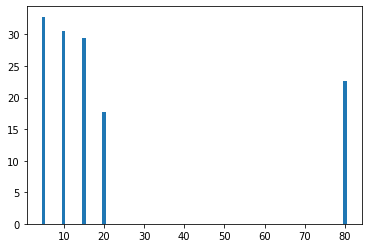

In [29]:
import matplotlib.pyplot as plt

plt.bar(list(proportion_of_correctly_predicted_keywords.keys()), list(proportion_of_correctly_predicted_keywords.values()))